# Проект: Прогнозирование рейтинга отеля на Booking.com

Титоренко Никита, @thetitorenko   
Студент SF DSPR, [Kaggle](https://www.kaggle.com/thetitorenko) | [GitHub](https://github.com/thetitorenko)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import requests
import re
from collections import Counter

import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split  

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Для визуализации облака тегов
from wordcloud import WordCloud    

# Проверка значимости признаков
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# Машинное обучение
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Для скрытия некоторых предупреждений
import warnings    
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\titor\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

RANDOM_SEED = 42

In [3]:
!pip freeze > requirements.txt

## Постановка проблемы

Представлю, что я работаю датасаентистом в компании [_Booking.com_](booking.com). Одна из проблем компании — это нечестные отели, которые "накручивают" себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

## 1. Подгрузка данных и исследование данных

In [4]:
# DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = '../data/'                                         # Для локальной работы
df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv')          # Датасет для обучения
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')             # Датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv')   # Сабмишн

In [5]:
print(df_train.info())
df_train.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [6]:
print(df_test.info())
df_test.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [7]:
print(sample_submission.info())
sample_submission.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB
None


,reviewer_score,id
0,1,488440
1,10,274649


Датасет содержит следующие кризнаки:
- `hotel_address` - адрес отеля
- `review_date` - дата, когда рецензент разместил соответствующий отзыв
- `average_score` - средний балл отеля, рассчитанный на основе последнего комментария за последний год
- `hotel_name` - название отеля
- `reviewer_nationality` - национальность рецензента
- `negative_review` - отрицательный отзыв, который рецензент дал отелю
- `review_total_negative_word_counts` - общее количество слов в отрицательном отзыв
- `positive_review` - положительный отзыв, который рецензент дал отелю
- `review_total_positive_word_counts` - общее количество слов в положительном отзыве
- `reviewer_score` - оценка, которую рецензент поставил отелю на основе своего опыта
- `total_number_of_reviews_reviewer_has_given` - количество отзывов, которые рецензенты дали в прошлом
- `total_number_of_reviews` - общее количество действительных отзывов об отеле
- `tags` - теги, которые рецензент дал отелю
- `days_since_review` - продолжительность между датой проверки и датой очистки
- `additional_number_of_scoring` - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки
- `lat` - широта отеля
- `lng` - долгота отеля

Два признака содержат пропуски: `lat` и `lng`. 

Целевой признак - `reviewer_score`. Метрика качества соревнования - _MAPE_.

Для обработки признаков объединяем датасеты `train` и `test`. Создаем признаки индикаторы датасетов для дальнейшего легко разделения, а также заполняем нулями целевой признак в `test`-датасете.

In [8]:
df_train['sample'] = 1          # Бинарный признак принадлежности к train-датасету
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### 1.1 Очистка данных

Очистка данных, в рамках платформы _Kaggle_, ограничиться заполнением пропусков в данных. Выбросы и дубликаты также будут проанализированы, но не обработаны.

Для заполнения пропущенных геоданных необходимо понимание о стране и городе. Признаков откуда сразу можно получить такие данные в датасете нету, таким образом их нужно извлечь из существующих, а это значит, что нужно будет немного "забежать" вперед, а именно на шаг проектирования признаков (_Feature Engineering_).

Для начала приведем признак даты в _datetime_, а также приведем в числовой тип признак `days_since_review`.

In [10]:
data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')

Извлечем признак города и страны из признака `hotel_address`, после чего удалим признак.

In [11]:
def get_country(address):
    address_splitted = address.split()
    if address_splitted[-1] == 'Kingdom':
        return ' '.join(address_splitted[-2:])
    return address_splitted[-1]


def get_city(address):
    address_splitted = address.split()
    if address_splitted[-1] == 'Kingdom':
        return address_splitted[-5]
    return address_splitted[-2]
    

data['country'] = data['hotel_address'].apply(lambda x: get_country(x))
data['city'] = data['hotel_address'].apply(lambda x: get_city(x))

data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample,country,city
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,51.507894,-0.143671,1,United Kingdom,London
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203,51.521009,-0.123097,1,United Kingdom,London
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289,48.845377,2.325643,1,France,Paris


In [12]:
dict_geo = {}

for i in range(len(data)):
    city = data['city'][i]
    lat = data['lat'][i]
    lng = data['lng'][i]
    if city not in dict_geo and not np.isnan(data['lat'][i]):
        dict_geo[city] = [lat, lng]

# Цикл поиска пропуска в геоданных и заполнением их по ключу города
for i in range(len(data)):
    if float(data['lat'][i]) >= 0:
        continue
    else:
        data['lat'][i] = dict_geo[data['city'][i]][0]
        data['lng'][i] = dict_geo[data['city'][i]][1]

data = data.drop('hotel_address', axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   hotel_name                                  515738 non-null  object        
 4   reviewer_nationality                        515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

Пропуски в данных устранены.

Пробуем посмотреть выбросы в числовых признаках визуализировав их с помощью коробчатых диаграмм (опустим разный масштаб данных признаков), а также выведем описательную статистку. Для начала сформируем список числовых признаков исключив из него явно не показательные геоданные и индикатор принадлежности к `train`-датасету.

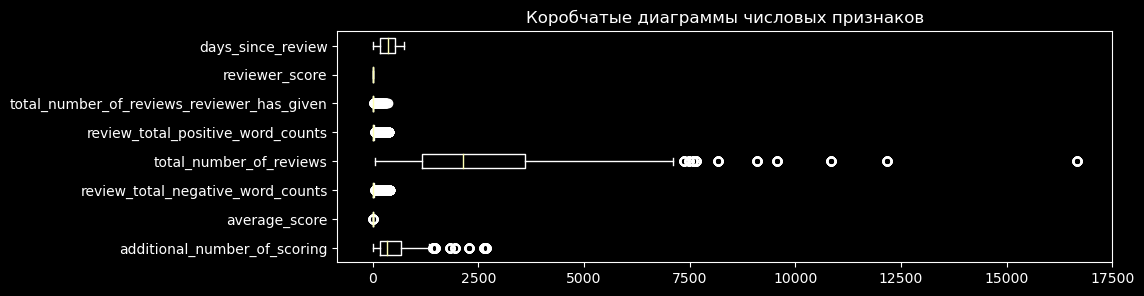

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,354.441932
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,208.928124
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,175.000000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,353.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,527.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,730.000000


In [13]:
outliers_review_cols = data.select_dtypes('number').drop(
    ['lat', 'lng', 'sample'], axis=1).columns

fig, ax = plt.subplots(figsize=(10, 3))
ax.boxplot(data[outliers_review_cols],
    vert=False, labels=outliers_review_cols)
ax.set_title('Коробчатые диаграммы числовых признаков')
plt.show();

data[outliers_review_cols].describe()

Хотя диаграммы и показывают наличие данных за пределами границ, но однозначно сказать, что это выбросы не представляется возможным, т.к. это могут быть вполне валидные данные.

Посмотрим на количество дублирующихся записей в датасете.

In [14]:
mask = data.duplicated()
data_duplicated = data[mask]
print('Число дублирующихся записей:', data_duplicated.shape[0])
print(f'Процент дубликатов в датасете: {round(1-(data.shape[0]-data_duplicated.shape[0])/ data.shape[0], 4)}%')

Число дублирующихся записей: 336
Процент дубликатов в датасете: 0.0007%


Дубликаты имеются, но их количество мало и значительно исказить метрику предсказания они не смогут.

## 2. Разведывательный анализ данных (EDA)

### 2.1 Проектирование признаков

Для начала проанализируем оставшиеся признаки на предмет возможности извлечения из них новых признаков, их кодирования или шкалирования их значений.

#### 2.1.1 Признаки страны и города (`country` и `city`)

Изучим внимательно созданные ранее признаки.

In [15]:
data[['country', 'city']].value_counts()

country         city     
United Kingdom  London       262301
Spain           Barcelona     60149
France          Paris         59928
Netherlands     Amsterdam     57214
Austria         Vienna        38939
Italy           Milan         37207
dtype: int64

Датасет содержит отели из 6 городов, которые расположены в 6 странах Европы. Большая часть отзывов составлена на отели Британии. Также заметна явная корреляция этих признаков, что потенциально может плохо влияет на модель.

Все города, за исключением двух (Испания, Италия), являются столицами. Из этого можем создать признак столицы (`is_capital`). Проверим гипотезу о том, что в столицах отели более хорошие.

In [16]:
capital = ['London', 'Paris', 'Amsterdam', 'Vienna']

data['is_capital'] = data['city'].apply(lambda x: 1 if x in capital else 0)

Добавим также экономические данные. Экономические показатели, такие как уровень безработицы, средний доход и ВВП на душу населения, могут дать представление о процветании и развитии города, что может повлиять на рейтинг отеля.

Ограничимся ВВП (_Gross Domestic Product_). Из открытых источником я получили следующие данные:
- Великобритания: 2,89 трлн долларов США
- Франция: 2,87 трлн долларов США
- Италия: 2,35 трлн долларов США
- Испания: 1,44 трлн долларов США
- Нидерланды: 943 млрд долларов США
- Австрия: 521 млрд долларов США

Закодируем данный признак порядковым кодированием по возрастанию показателя соответствующей страны.

In [17]:
gdp = {
    'Austria': 1, 'Netherlands': 2, 'Spain': 3,
    'Italy': 4, 'France': 5, 'United Kingdom': 6
    }

data['gdp'] = data['country'].apply(lambda x: gdp[x])

Исходные признаки закодируем методом _One-hot encoding_.

In [18]:
country = pd.get_dummies(data['country'], prefix='country')
city = pd.get_dummies(data['city'], prefix='city')
data = pd.concat([data, country, city], axis=1)

#### 2.1.2 Признак даты размещения отзыва (`review_date`)

Данный признак уже был преобразован в формат даты, поэтому его можно легко визуализировать. Для начала посмотрим временные границы, охватываемые данными.

In [19]:
data['review_date'].agg(['min', 'max']).rename({'min': 'Начало', 'max': 'Конец'})

Начало   2015-08-04
Конец    2017-08-03
Name: review_date, dtype: datetime64[ns]

Данные представлены за два года: начиная с августа 2015 и заканчивая августом 2017. В формате datetime наша модель данные не принимает и поэтому их нужно закодировать. Так как данные имеют цикличный шаблон, то их можно преобразовать с помощью циклического кодирования. Это может быть сделано путем преобразования значений в признаки синуса и косинуса, которые вместе будут интерпретированы моделью как периодические паттерны.

Выполним преобразование вручную по следующим формулам ([источник](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning)):

$x_{\sin}=\sin(\frac{2*\pi*x}{max(x)})$

$x_{\cos}=\cos(\frac{2*\pi*x}{max(x)})$

В качестве временного периода будем использовать день года. Максимальное значение - последний номер последнего дня в году.

In [20]:
def get_cyclic_encoding(df:pd.DataFrame, feature:str):
    x = df[feature]
    sin_x = np.sin((2 * np.pi * x.dt.dayofyear) / x.dt.dayofyear.max())
    cos_x = np.cos((2 * np.pi * x.dt.dayofyear) / x.dt.dayofyear.max())
    df[feature + '_sin_x'] = sin_x
    df[feature + '_cos_x'] = cos_x
    return df

data = get_cyclic_encoding(data, 'review_date')

#### 2.1.3 Признаки положительного и отрицательного отзыва (`positive_review` и `negative_review`)

Известно, что люди чаще пишут негативные отзывы, чем положительные. А это значит, что нам весь интересно получить какую-то числовую оценку отзыва на основании текста отзыва для проверки гипотезы.

Данные признаки представлены в текстовом предобработанном виде (удалены знаки препинания, тире, и т.д.). В датасете уже имеются сильные признаки извлеченные из данных - признаки количества слов в каждом положительном и отрицательном отзыве.

Для дальнейшей обработки признака будет использована библиотека для работы с естественными языками - _Natural Language Toolkit (NLTK)_. Данная библиотека получает на вход текст обзора и производит токенизацию каждого слова и распознает оттенок текста: нейтральный, негативный или положительный. Я буду использовать два последних оттенка для распознавания обзоров и создания новых признаков для нашего датасета.

In [21]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_analysis(review, shade):
    return analyzer.polarity_scores(review)[shade]


data['positive_review_analyzed'] = data['positive_review'].apply(
    lambda x: get_sentiment_analysis(x, 'pos'))
data['negative_review_analyzed'] = data['negative_review'].apply(
    lambda x: get_sentiment_analysis(x, 'neg'))

#### 2.1.4 Признак тегов (`tags`)

Тег представлен в достаточно сложном виде - список тегов поставленные пользователем под обзором, который затем "в лоб" преобразован в строку.

Для начало посмотрим сколько всего тегов представлено. Для облегчения задачи будем использовать `Counter` из библиотеки `collections`. Это позволяет нам легко подсчитывать элементы в повторяющемся (в нашем случаи теги) списке.

In [22]:
tag_dict = Counter()

def get_tag(tags):
    regex = "\'(.*?)\'"
    tags_splitted = re.split(regex, tags)
    for tag in tags_splitted:
        if len(tag) > 3:
            tag_dict[tag[1:-1]] += 1


data['tags'].apply(lambda x: get_tag(x))

print('Уникальных тегов в датасете:', len(tag_dict.keys()))

Уникальных тегов в датасете: 2428


Посмотрим топ 10 тегов по полярности использования, а также построим облако слов (тегов).

[('Leisure trip', 417778), ('Submitted from a mobile device', 307640), ('Couple', 252294), ('Stayed 1 night', 193645), ('Stayed 2 nights', 133937), ('Solo traveler', 108545), ('Stayed 3 nights', 95821), ('Business trip', 82939), ('Group', 65392), ('Family with young children', 61015)]


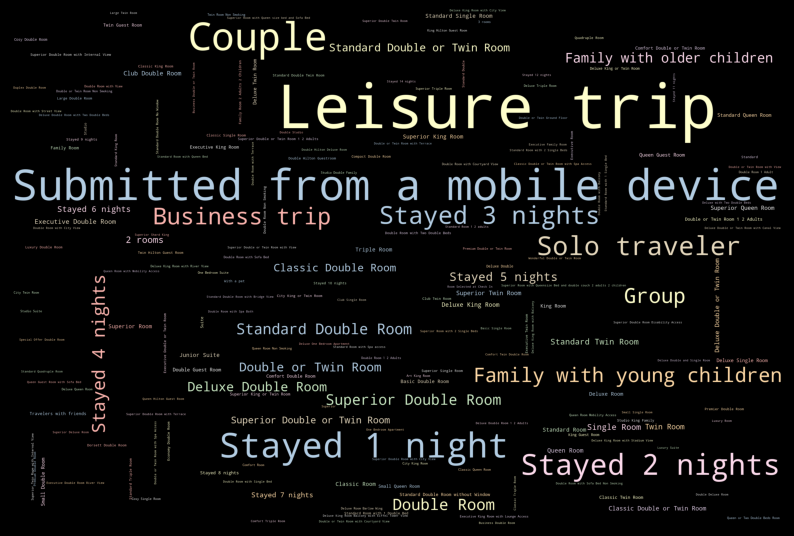

In [23]:
print(tag_dict.most_common(10))

wordcloud = WordCloud(
    width=3000, height=2000, random_state=RANDOM_SEED,
    background_color='black', colormap='Pastel1',
    ).generate_from_frequencies(tag_dict)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off');

**2428** тега явно много для кодирования их любыми известным методом. 

Необходимо выделить основные паттерны тегов и закодировать их подходящим способом:
- **Вид поездки**: 
    - поездка на отдых (_Leisure trip_)
    - командировка (_Business trip_))
- **Количество ночей**: 
    - останавливались на 1 ночь (_Stayed 1 night_)
    - останавливались на 2 ночи (_Stayed 2 nights_)
    - останавливались на ...
- **Количество проживающих людей**: 
    - пара (_Couple_)
    - группа (_Group_)
    - путешественник-одиночка (_Solo traveler_)
    - путешественники с друзьями (_Travelers with friends_)
    - семья с маленькими детьми (_Family with young children,_)
    - семья с детьми старшего возраста (_Family with older children_)
- **Класс номера**
- **Возможность брать животное** (_With a pet_)
- **С какого устройства отравлен отзыв** (_Submitted from a mobile device_)

##### 2.1.4.1 Тег количества ночей (`stayed_nights`)

In [24]:
def get_tags_list(tags):
    tags_list = []
    regex = "\'(.*?)\'"
    tags_splitted = re.split(regex, tags)
    for tag in tags_splitted:
        if len(tag) > 3:
            tags_list.append(tag[1:-1])
    return tags_list


def get_stayed_nights(data, feature):
    df = pd.DataFrame(data[feature])
    df['stayed_nights'] = np.nan
    for i in range(len(df)):
        tags_list = get_tags_list(df[feature][i])
        for tag in tags_list:
            if 'stayed' in tag.lower():
                df['stayed_nights'][i] = tag.split()[1]
    return df['stayed_nights']


stayed_nights = get_stayed_nights(data, 'tags')
stayed_nights = stayed_nights.fillna(stayed_nights.median()).astype('int')

print('Количество значений признака:', len(stayed_nights.value_counts()))

Количество значений признака: 31


Агрегируем номер дня года (данные у нас за два года), чтобы показать среднее значение дней отдыха на этот день.

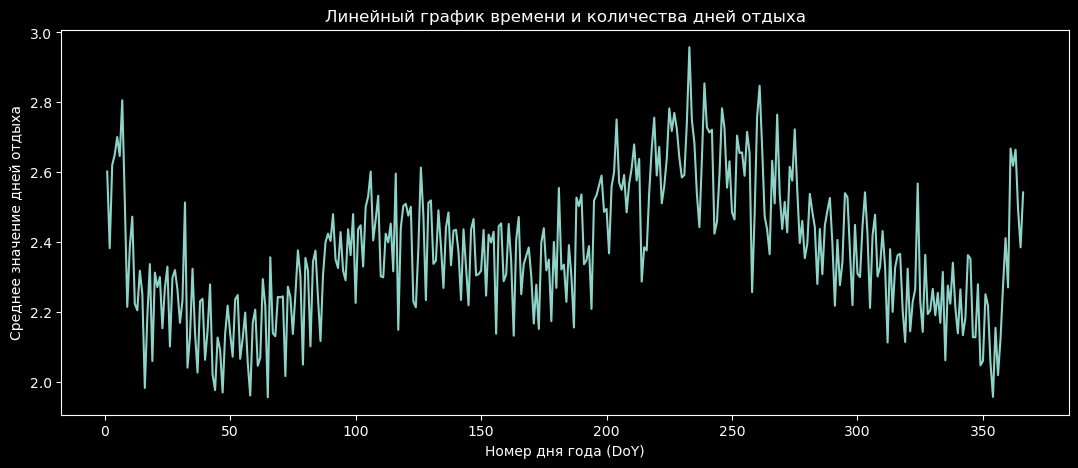

In [25]:
data_temp = pd.concat([data, stayed_nights], axis=1)
data_temp['review_date'] = data_temp['review_date'].dt.dayofyear
data_temp.groupby('review_date')['stayed_nights'].mean().plot(
    kind='line',
    title='Линейный график времени и количества дней отдыха',
    xlabel='Номер дня года (DoY)',
    ylabel='Среднее значение дней отдыха',
    figsize=(13, 5));

Из визуализации видны два пика: новогодние праздники, а также последние дни лета. В эти дни посетители были склоны отдыхать дольше.

Признак содержит более 20 значений, поэтому для его кодировки будем использовать бинарное кодирование. А также удалим признак даты, т.к. далее он нам не понадобиться.

In [26]:
encoder = ce.BinaryEncoder(cols='stayed_nights')
bin_encoded = encoder.fit_transform(pd.DataFrame(stayed_nights))
data = pd.concat([data, bin_encoded], axis=1)

data = data.drop('review_date', axis=1)

##### 2.1.4.2 Тег класса номера (`room_class`)

Частота использования тега с классом номера определенно говорит о его значимой роли в оценке отеля клиентов. Попробуем проверить данную гипотезу.

Класс номера достаточно трудно отсортировать по категории, поскольку цены на гостиничные номера могут сильно варьироваться в зависимости от таких факторов, как местоположение, сезон, спрос, а также конкретные предлагаемые удобства и особенности. Тем не менее, основываясь на данных сервисов по бронированию номеров можно составить список отражающий ценовой диапазон для различных типов гостиничных номеров, от самых низких до самых высоких:
1. Стандартный номер (_Standard room_)
2. Классический номер (_Classic room_)
3. Номер с двуспальной кроватью (_Queen room_)
4. Двухместный номер с 1 кроватью (_Double room_)
5. Двухместный номер с 2 отдельными кроватями (_Twin room_)
6. Клубная комната (_Club room_)
7. Студия (_Studio_)
8. Семейный номер (_Family room_)
9. Улучшенный номер (_Superior room_)
10. Номер повышенной комфортности (_Deluxe room_)
11. Представительский номер (_Executive room_)
12. Номер люкс (_Suite_)
13. Президентский люкс (_Presidential suite_)

На основе этих создадим числовой порядковый признак класса номера. Неопределенные алгоритмом номера (_NaN_) заполним средним значением.

In [27]:
room_classes = {
    'Standard': [1, 'Стандартный номер'],
    'Classic': [2, 'Классический номер'],
    'Queen': [3, 'Номер с двуспальной кроватью'],
    'Double': [4, 'Двухместный номер с 1 кроватью'],
    'Twin': [5, 'Двухместный номер с 2 отдельными кроватями'],
    'Club': [6, 'Клубная комната'],
    'Studio': [7, 'Студия'],
    'Family': [8, 'Семейный номер'],
    'Superior': [9, 'Улучшенный номер'],
    'Deluxe': [10, 'Номер повышенной комфортности'],
    'Executive': [11, 'Представительский номер'],
    'Suite': [12, 'Номер люкс'],
    'Presidential': [13, 'Президентский люкс']
    }


def get_room_class(data, feature):
    df = pd.DataFrame(data[feature])
    search_mask = ['room', 'suite', 'studio']
    df['room_class'] = np.nan
    for i in range(len(df)):
        tags_list = get_tags_list(df[feature][i])
        for tag in tags_list:
            for mask in search_mask:
                if mask in tag.lower():
                    for room_class, class_num in room_classes.items():
                        if room_class.lower() in tag.lower():
                            df['room_class'][i] = class_num[0]
    return df['room_class']


room_class = get_room_class(data, 'tags')
room_class = room_class.fillna(room_class.mean())
data = pd.concat([data, room_class], axis=1)

Визуализируем получившийся признак.

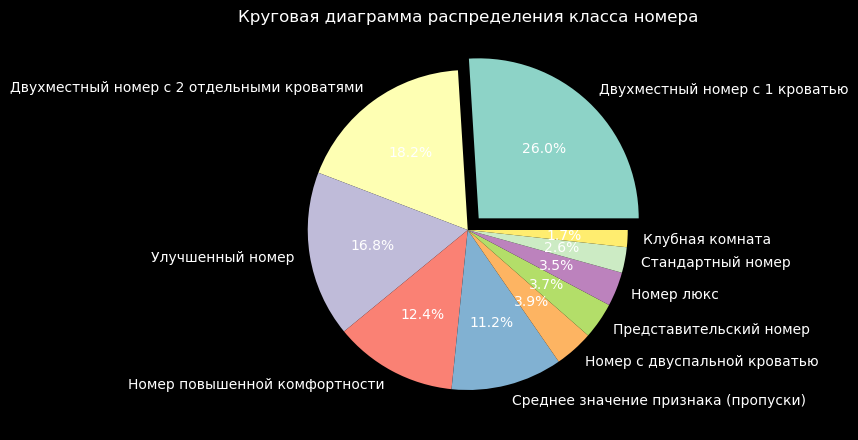

In [28]:
pie_labels = []

for class_num in room_class.value_counts().index:
    for value in room_classes.values():
        if class_num == value[0]:
            pie_labels.append(value[1])
        elif round(class_num, 5) == round(room_class.mean(), 5):
            pie_labels.append('Среднее значение признака (пропуски)')
            break

fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.pie(
    data['room_class'].value_counts().nlargest(10),
    autopct='%.1f%%',
    labels=pie_labels[:10],
    explode=[0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )
ax.set_title('Круговая диаграмма распределения класса номера');

Самые популярные номера - двухместные номера с 1 кроватью (_Double_).

##### 2.1.4.3 Тег количества проживающих людей и другие оставшиеся теги

Данные признаки закодируем как бинарные.

In [29]:
def get_binary_feature(data, feature, new_feature, prefix):
    df = pd.DataFrame(data[feature])
    new_feature_name = prefix + '_' + '_'.join(new_feature.split())
    df[new_feature_name] = 0
    for i in range(len(df)):
        tags_list = get_tags_list(df[feature][i])
        for tag in tags_list:
            if new_feature in tag.lower():
                df[new_feature_name][i] = 1
    return df[new_feature_name]

couple = get_binary_feature(data, 'tags', 'couple', 'living')
group = get_binary_feature(data, 'tags', 'group', 'living')
solo_traveler = get_binary_feature(data, 'tags', 'solo traveler', 'living')
with_friends_traveler = get_binary_feature(data, 'tags', 'travelers with friends', 'living')
young_children = get_binary_feature(data, 'tags', 'family with young children', 'living')
older_children = get_binary_feature(data, 'tags', 'family with older children', 'living')
with_pet = get_binary_feature(data, 'tags', 'with a pet', 'bin')
mobile_sub = get_binary_feature(data, 'tags', 'submitted from a mobile device', 'bin')

data = pd.concat([
    data, couple, group, solo_traveler, with_friends_traveler, young_children,
    older_children, with_pet, mobile_sub], axis=1)

Тип вида поездки закодируем так: `1` - поездка на отдых (_Leisure trip_), `0` - командировка (_Business trip_).

In [30]:
def get_trip_type(tags):
    tags_list = get_tags_list(tags)
    if 'Leisure trip' in tags:
        return 1
    if 'Business trip' in tags:
        return 0

data['trip'] = data['tags'].apply(lambda x: get_trip_type(x))
data['trip'] = data['trip'].fillna(data['trip'].median()).astype('int')

#### 2.1.5 Признак национальность рецензента (`reviewer_nationality`)

Для принятия решения о методе кодировки данного категориального признака нужно понять количество уникальных значений.

In [31]:
data['reviewer_nationality'].nunique()

227

Для кодирования данного количества значений признака применим бинарный кодировщик.

In [32]:
encoder = ce.BinaryEncoder(cols='reviewer_nationality')
bin_encoded = encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, bin_encoded], axis=1)

#### 2.1.6 Признак названия отеля (`hotel_name`)

И в самом конце подходим к признаку отеля из которого, на первый взгляд, мало что можно извлечь.

Однако если поискать по имени отеля информацию на сайтах бронирования гостиниц, то можно увидеть рейтинг отеля - количество звезд (от 1 до 5). Для начала посмотрим на количество уникальных значений признака.

In [33]:
data['hotel_name'].nunique()

1492

Гостиниц довольно много и вручную получить желанный рейтинг, в приемлемые временные сроки, не представляется возможным . Для автоматизации процесса воспользуемся веб-скрабингом сайта [Hotels.com](https://hotels.com) с помощью библиотеки `selenium`. 

>Скрипт для скрабинга рейтинга гостиницы не включен в данный ноутбук, т.к. процесс хоть и автоматический, но занимает продолжительное время. Ознакомиться со скриптом можно [тут](https://github.com/thetitorenko/sf_data_science/blob/main/project_3/scraping_hotels_v2.py).

Благодаря веб-скрабингу я получил датасет с названием гостиницы (взятого из нашего первоначального датасета), ее рейтингом и ссылкой на страницу на сайте Hotels.com (вдруг я надумаю в дальнейшем ещё скрабить какую-то информацию).

Подгрузим датасет и посмотрим на него.

In [34]:
url = 'https://github.com/thetitorenko/sf_data_science/blob/main/project_3/hotels_scraping.csv?raw=true'
hotels_scraping = pd.read_csv(url)
display(hotels_scraping.head())
print(hotels_scraping.info())

,hotel_name,scraped_info
0,Britannia International Hotel Canary Wharf,"[3.5, 'https://www.hotels.com/ho114099/britann..."
1,Strand Palace Hotel,"[4.0, 'https://www.hotels.com/ho114409/the-str..."
2,Park Plaza Westminster Bridge London,"[4.0, 'https://www.hotels.com/ho335698/park-pl..."
3,Copthorne Tara Hotel London Kensington,"[4.0, 'https://www.hotels.com/ho150368/copthor..."
4,DoubleTree by Hilton Hotel London Tower of London,"[4.0, 'https://www.hotels.com/ho368307/doublet..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   hotel_name    1392 non-null   object
 1   scraped_info  1392 non-null   object
dtypes: object(2)
memory usage: 21.9+ KB
None


В данных есть пропуски - заполним их позже. Пока объединим датасеты.

In [35]:
def merge_datasets_star(hotel_name):
    mask = hotels_scraping['hotel_name'] == hotel_name
    try:
        rating = hotels_scraping[mask]['scraped_info'].values[0][1:4]
        return float(rating)
    except:
        return np.nan

data['star'] = data['hotel_name'].apply(lambda x: merge_datasets_star(x))

In [36]:
def merge_datasets_url(hotel_name):
    mask = hotels_scraping['hotel_name'] == hotel_name
    try:
        url_draft = hotels_scraping[mask]['scraped_info'].values[0]
        regex = "\'(.*?)\'"
        url_full = re.split(regex, url_draft)[1]
        delimiter = url_full.index('?')
        short_url = url_full[:delimiter]
        return short_url
    except:
        return np.nan

data['url_short'] = data['hotel_name'].apply(lambda x: merge_datasets_url(x))

Визуализируем количество отелей определенного рейтинга по каждому городу.

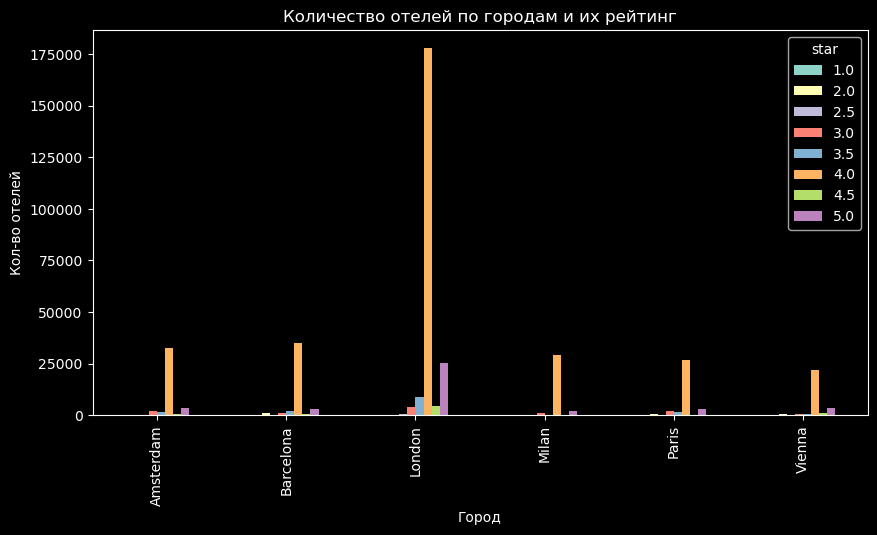

In [37]:
data.pivot_table(
    values='hotel_name', index='city', columns= 'star', aggfunc='count'
    ).plot(
        kind='bar', title='Количество отелей по городам и их рейтинг',
        figsize=(10, 5), xlabel='Город', ylabel='Кол-во отелей');

В датасете преобладают отели с рейтингом 4 звезды.

Настало время избавиться от пропусков - заполним их медианным значением признака.

In [38]:
data['star'] = data['star'].fillna(data['star'].median())

Название отеля также представляет интерес, поэтому закодируем его.

In [39]:
encoder = ce.BinaryEncoder(cols='hotel_name')
bin_encoded = encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, bin_encoded], axis=1)

Есть еще гипотеза о том, что в среднем оценка отеля примерно одинаковая на всех сайтах по агрегации отелей. Раз уже есть ссылки на карточки отелей на сайте _Hotels.com_, то можно также сделать веб-скрабинг и получить пользовательский рейтинг отелей с данного сайта.

Если какой-то отель "накручивает" себе рейтинг на Booking.com, то она должна отличать на другом сайте. Конечно, возможно, что отель накручивает рейтинг и на другом сайте, но в рамках нашего исследования я исключаю этот момент.

Для получения еще одной оценки, можно сказать еще одного таргета, был написан [скрипт](https://github.com/thetitorenko/sf_data_science/blob/main/project_3/scraping_other_target.py). Веб-скрабинг проводился отдельно и в ноутбук подгружается уже готовый датасет.

In [40]:
url = 'https://github.com/thetitorenko/sf_data_science/blob/main/project_3/hotels_other_target.csv?raw=true'
hotels_other_target = pd.read_csv(url)
hotels_other_target.head()

,hotel_name,url_short,other_rating
0,Britannia International Hotel Canary Wharf,https://www.hotels.com/ho114099/britannia-the-...,6.2
1,Strand Palace Hotel,https://www.hotels.com/ho114409/the-strand-pal...,8.4
2,Park Plaza Westminster Bridge London,https://www.hotels.com/ho335698/park-plaza-wes...,8.4
3,Copthorne Tara Hotel London Kensington,https://www.hotels.com/ho150368/copthorne-tara...,7.0
4,DoubleTree by Hilton Hotel London Tower of London,https://www.hotels.com/ho368307/doubletree-by-...,8.2


In [41]:
data = pd.merge(
    data, hotels_other_target[['hotel_name', 'other_rating']], how='left'
    )

data['other_rating'].fillna(data['other_rating'].mean(), inplace=True)

Посмотрим на среднюю оценку разницу в оценку в отзывах по городам.

In [42]:
temp_data = data[['city', 'reviewer_score', 'other_rating']]
temp_data['diff'] = temp_data['reviewer_score'].sub(temp_data['other_rating'])
temp_data = temp_data.groupby(['city'])['city', 'reviewer_score', 'other_rating', 'diff'].mean()
temp_data

,reviewer_score,other_rating,diff
city,,,
Amsterdam,6.351014,8.677349,-2.326336
Barcelona,6.418190,8.619796,-2.201606
London,6.246694,8.260027,-2.013333
Milan,6.261615,8.496185,-2.234570
Paris,6.299141,8.488063,-2.188923
Vienna,6.408716,8.633352,-2.224636


Гипотез не подтверждается. Оказывается на сайте _Hotels.com_ пользователи в среднем более добрые. Безусловно имеет место временной период (датасет _Booking.com_ старее на 5 лет), но полученный веб-скрабингом признак тоже представляется собой среднее значение. В общем интересная закономерность. Оставим данный признак в наших данных. 

### 2.3 Преобразование признаков

Признаки в датасете представлены в разных масштабах и их можно предобработать - сделать маштабирование. Однако для выбраного алгоритма, а именно _Random Forest Regressor_, такие преобразование ухудшают итоговую метрику. Следоватьльно данный пункт подготовки данных пропускаем.

In [43]:
# Вывод всех числовых колонок без обрезания
pd.set_option('display.max_columns', 0)
data.select_dtypes('number').describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,sample,is_capital,gdp,country_Austria,country_France,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,review_date_sin_x,review_date_cos_x,positive_review_analyzed,negative_review_analyzed,stayed_nights_0,stayed_nights_1,stayed_nights_2,stayed_nights_3,stayed_nights_4,room_class,living_couple,living_group,living_solo_traveler,living_travelers_with_friends,living_family_with_young_children,living_family_with_older_children,bin_with_a_pet,bin_submitted_from_a_mobile_device,trip,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,star,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,other_rating
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,354.441932,49.432362,2.893445,0.749999,0.811230,4.568382,0.075502,0.116199,0.072143,0.110936,0.116627,0.508594,0.110936,0.116627,0.508594,0.072143,0.116199,0.075502,-0.006079,-0.051592,0.388488,0.322670,0.001241,0.020617,0.161078,0.608303,0.549358,6.451799,0.489190,0.126793,0.210465,0.004155,0.118306,0.051090,0.002724,0.596504,0.839184,0.003128,0.049019,0.185773,0.195545,0.262922,0.323383,0.184283,0.707031,4.039857,0.095136,0.287896,0.374871,0.442727,0.459605,0.508386,0.512590,0.512850,0.506994,0.495785,0.481159,8.420003
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,208.928124,3.460240,4.667412,0.433014,0.391326,1.751401,0.264199,0.320463,0.258725,0.314053,0.320976,0.499927,0.314053,0.320976,0.499927,0.258725,0.320463,0.264199,0.705728,0.706577,0.235558,0.410258,0.035205,0.142099,0.367603,0.488130,0.497558,2.781967,0.499884,0.332741,0.407640,0.064327,0.322971,0.220181,0.052123,0.490599,0.367362,0.055837,0.215908,0.388923,0.396620,0.440221,0.467768,0.387716,0.455125,0.355079,0.293402,0.452783,0.484090,0.496709,0.498366,0.499930,0.499842,0.499835,0.499952,0.499983,0.499645,0.652375
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,41.328376,-0.369758,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.999963,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,175.000000,48.213305,-0.143372,0.250000,1.000000,3.000000,0.000000,0.0000

### 2.2 Отбор признаков

Убираем признаки которые еще не успели обработать, модель на признаках с `dtypes "object"` обучаться не будет, просто выберем их и удалим.

In [44]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

#### 2.2.1 Мультиколлинеарность

Для анализа на мультиколлинеарность будем использовать метод Пирсона для числовых признаков, и метод Спирмена для категориальных. 

Выделим признаки в списки и проверим их.

In [45]:
num_cols = [
    'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
    'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
    'reviewer_score', 'days_since_review', 'other_rating'
    ]

cat_cols = [col for col in data.columns if col not in num_cols]

In [46]:
def get_correlation(df, cols_list, method='pearson', multicorr_edge=0.7):
    df_corr = df[cols_list].corr(method=method)
    multicoll_cols = []
    annot=True
    
    # проход по значениям таблицы
    for col in df_corr.columns:
        for i in range(len(df_corr)):
            if df_corr[col][i] == 1:
                continue
            elif df_corr[col][i] < -multicorr_edge or df_corr[col][i] > multicorr_edge:
                corr = round(df_corr[col][i], 2)
                multicoll_cols.append(f'{df_corr.index[i]}--{col}: корреляция {corr}')
    
    # вывовод списка признаков
    print(f'Пары признаков с корреляцией больше {multicorr_edge}:')
    if multicoll_cols:
        for corr in multicoll_cols:
            print(f'    {corr}')
    else:
        print('    признаков с заданой границой КК не найдено')
    
    # читаемость графика
    if len(cols_list) > 15:
        annot=False
    
    print('Визуализация всех корреляций:')
    plt.rcParams['figure.figsize'] = (15, 10)
    return sns.heatmap(df_corr, annot=annot)

Пары признаков с корреляцией больше 0.7:
    total_number_of_reviews--additional_number_of_scoring: корреляция 0.82
    additional_number_of_scoring--total_number_of_reviews: корреляция 0.82
Визуализация всех корреляций:


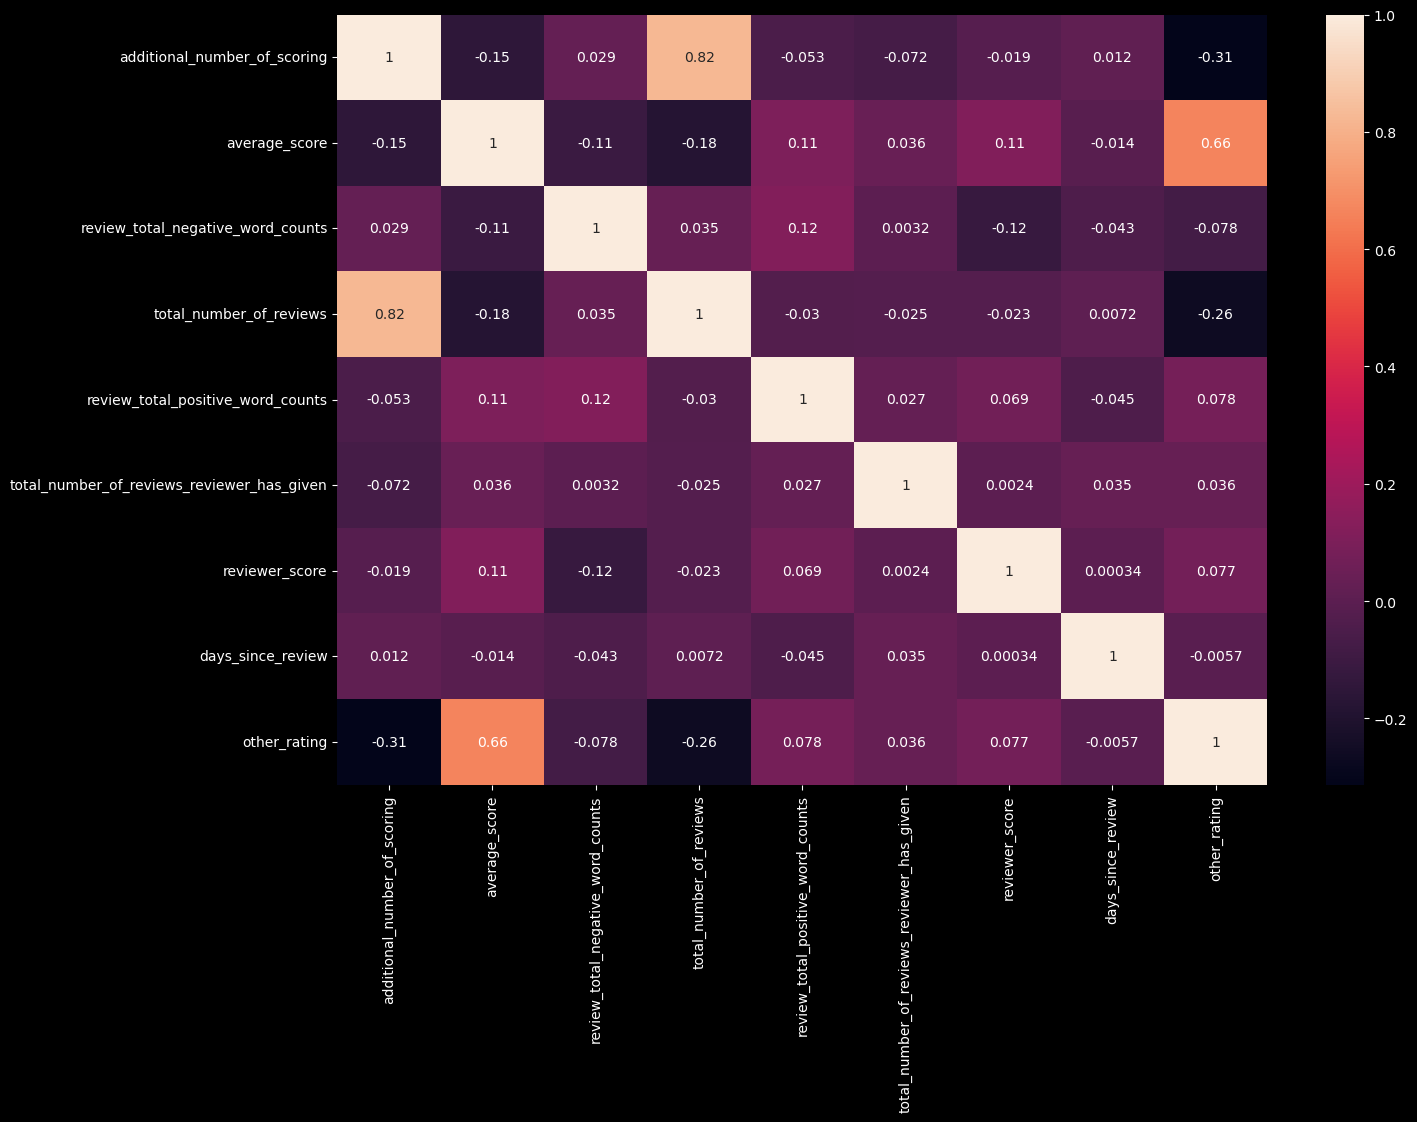

In [47]:
get_correlation(data, num_cols);

Пары признаков с корреляцией больше 0.7:
    gdp--lng: корреляция -0.86
    country_United Kingdom--lng: корреляция -0.87
    city_London--lng: корреляция -0.87
    country_Spain--is_capital: корреляция -0.75
    city_Barcelona--is_capital: корреляция -0.75
    lng--gdp: корреляция -0.86
    country_United Kingdom--gdp: корреляция 0.93
    city_London--gdp: корреляция 0.93
    is_capital--country_Spain: корреляция -0.75
    lng--country_United Kingdom: корреляция -0.87
    gdp--country_United Kingdom: корреляция 0.93
    is_capital--city_Barcelona: корреляция -0.75
    lng--city_London: корреляция -0.87
    gdp--city_London: корреляция 0.93
Визуализация всех корреляций:


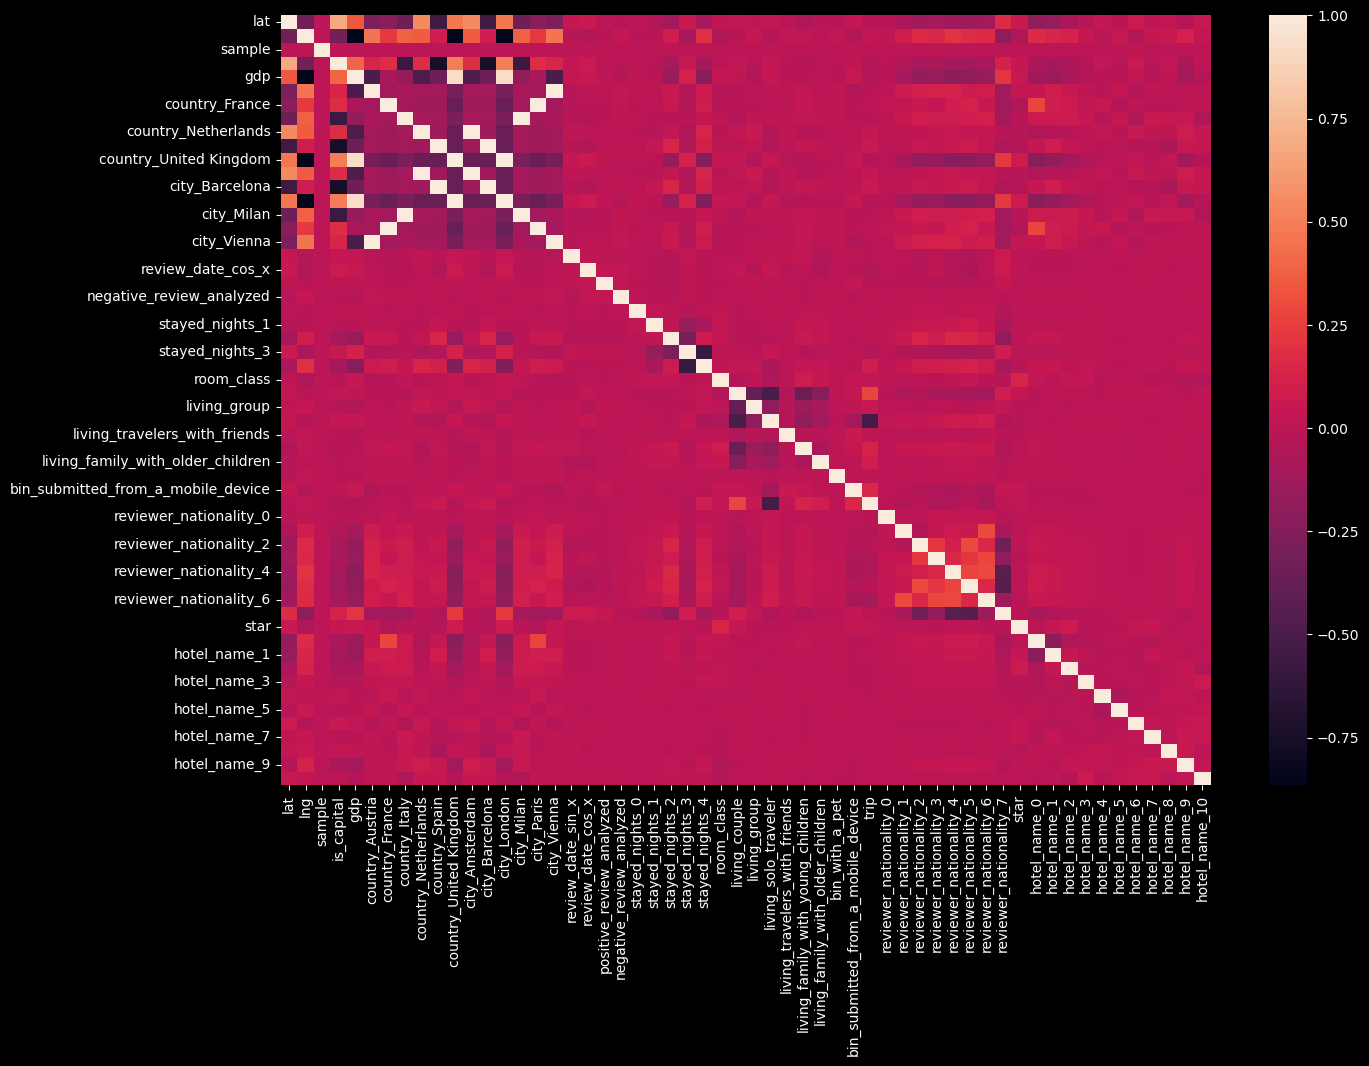

In [48]:
get_correlation(data, cat_cols, method='spearman');

К сожалению признаки столицы и ВВП показали мультиколлинеарный уровень корреляции. Также из-за большого количества отелей в датасете, которые расположены в Лондоне, придется пожертвовать несколькими бинарными признаками.

Удалим признаки на мой экспертный взгляд (полученный опытным путем).

In [49]:
drop_cols = [
    'is_capital', 'city_Barcelona', 'country_Spain', 
    'city_London', 'city_Vienna', 'country_United Kingdom', 
    'country_Austria']
data = data.drop(drop_cols, axis=1)

#### 2.2.2 Значимость признаков

Перед следующим этапом разделим данные на `train`-датасет и `test`-датасет.

In [50]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['reviewer_score'].values    # Наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке `sklearn.feature_selection.chi2`.

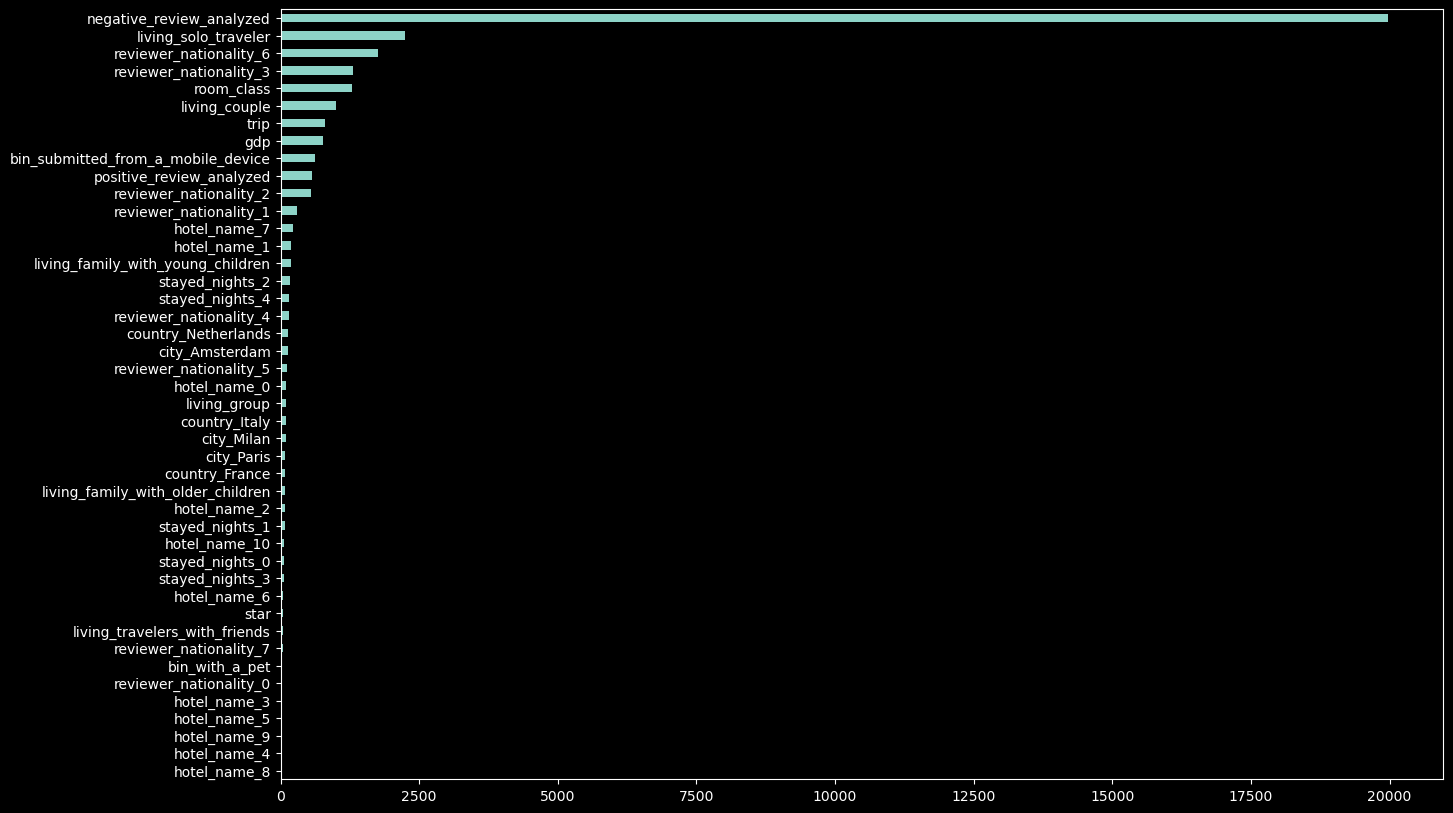

In [51]:
y=y.astype('int')

# Удаляем метку разделитель и удаленные ранее признаки
cat_cols.remove('sample')
cat_cols = [col for col in cat_cols if col not in drop_cols]

# Тест не принимает отрицательные значения признака - удаляем их
cat_cols.remove('lat')
cat_cols.remove('lng')
cat_cols.remove('review_date_sin_x')
cat_cols.remove('review_date_cos_x')

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

Для оценки значимости непрерывных переменных будем использовать функцию `f_classif` из библиотеки `sklearn`.

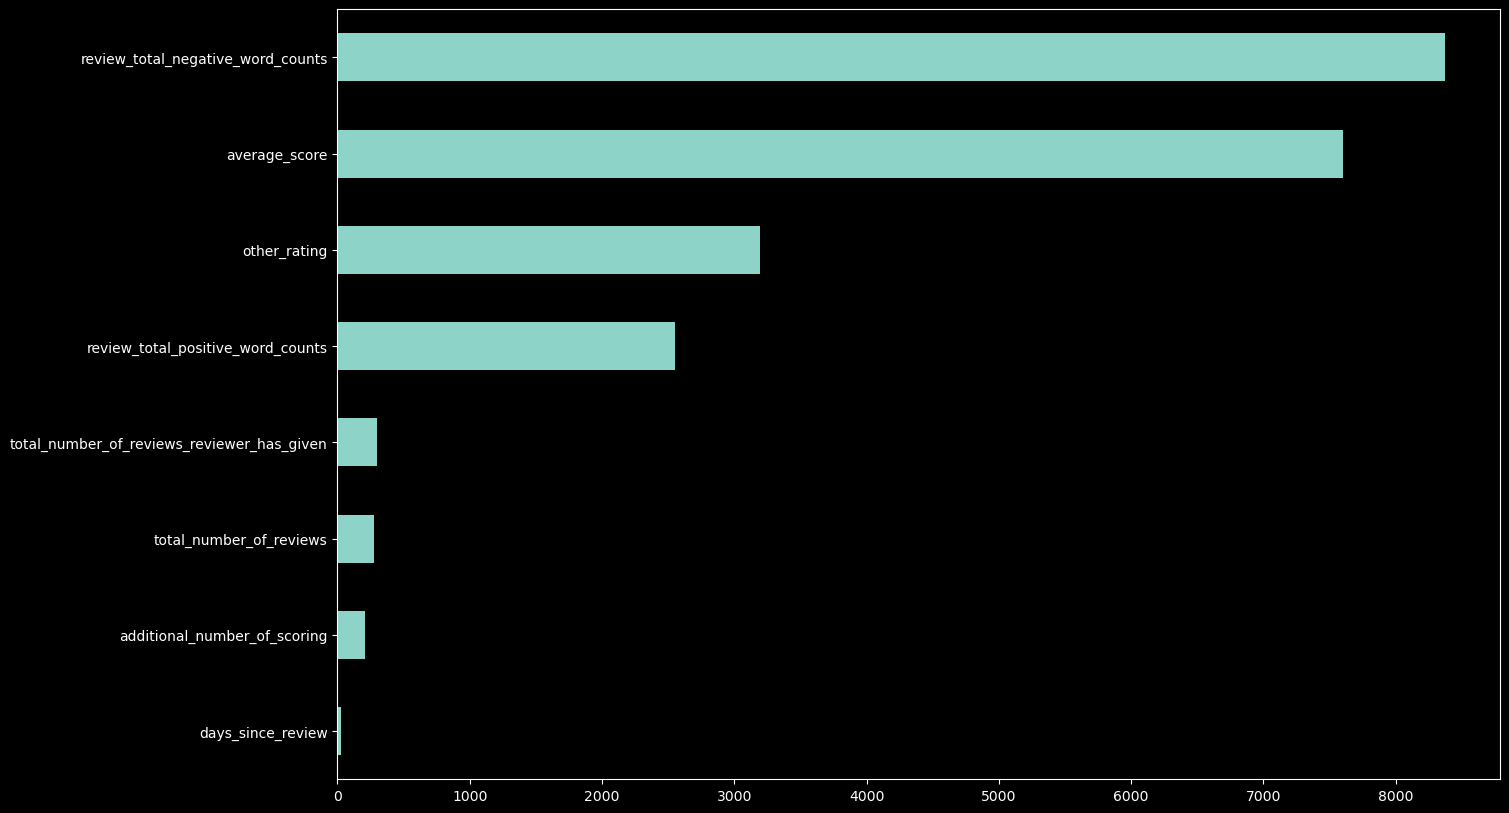

In [52]:
# Удаляем таргет
num_cols.remove('reviewer_score')

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh');

Гипотеза об влиянии количества звезд на итоговую оценку рецензента не подтвердилась.

Зато гипотеза о значимости класса номера на таргет исследования подтверждается. Тажке как и значимость оттенка негативного отзыва - она показывает очень высокую значимость.

_К сожалению, если удалить малозначимые признаки модель начинала показывать более низкую метрику. Поэтому в датасете были оставлены все признаки._

## Обучение модели

Воспользуемся специальной функцией `train_test_split` для разбивки тестовых данных и выделим 20% данных на валидацию (параметр `test_size`). Снова разделим данные на `train`-датасет и `test`-датасет.

In [53]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['reviewer_score'].values    # Наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 57), (386803, 57), (386803, 56), (309442, 56), (77361, 56))

In [55]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [56]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


Сравниваем предсказанные значения (`y_pred`) с реальными (`y_test`), и смотрим насколько они в среднем отличаются

Метрика называется _Mean Absolute Percentage Error (MAPE)_ и показывает среднее отклонение предсказанных значений от фактических.

In [57]:
print('MAPE:', round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5))

MAPE: 0.12871


Выведем самые важные признаки для модели.

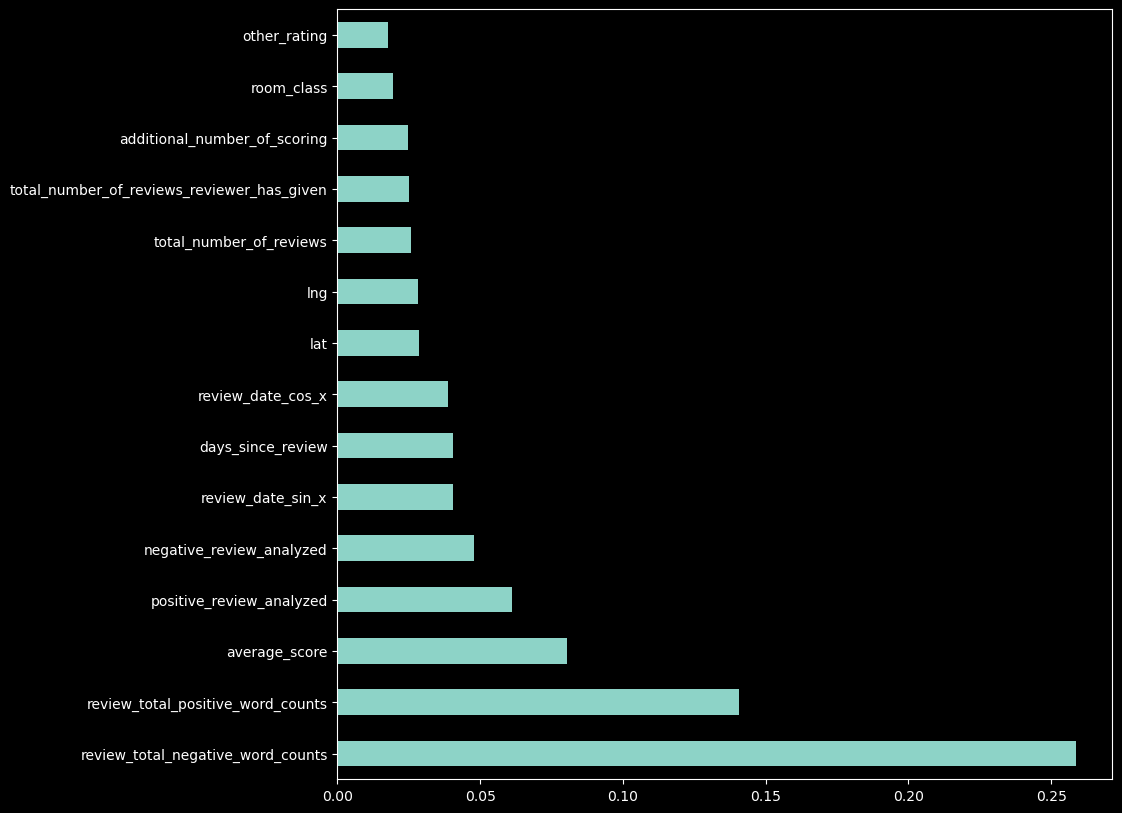

In [58]:
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

Предскажем с помощью нашей модели значения в test-датасете и заполним ими submission.

In [59]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


In [60]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.567,488440
1,7.385,274649
2,8.583,374688
3,9.701,404352
4,9.507,451596
5,8.323,302161
6,7.688,317079
7,7.161,13963
8,8.146,159785
9,7.635,195089
